# Decision Tree Classification on Titanic Dataset

This notebook implements a comprehensive Decision Tree machine learning model to predict passenger survival on the Titanic based on passenger characteristics and travel details.

## Dataset Information
- **Source**: Titanic: Machine Learning from Disaster (Kaggle)
- **Training samples**: 891 passengers
- **Test samples**: 418 passengers  
- **Features**: 11 features including passenger class, age, sex, fare, etc.
- **Target**: Binary classification (survived vs died)
- **Historical Context**: RMS Titanic sank on April 15, 1912, during its maiden voyage

## Objective
Build a Decision Tree classifier to understand the key factors that influenced passenger survival and make accurate predictions about survival probability based on passenger characteristics.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Data Loading and Exploration


In [2]:
# Load the Titanic dataset
train_data = pd.read_csv('../datasets/titanic/train.csv')
test_data = pd.read_csv('../datasets/titanic/test.csv')

print("Dataset loaded successfully!")
print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")
print(f"Training memory usage: {train_data.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Display first few rows
print("\nFirst 5 rows of training data:")
train_data.head()


Dataset loaded successfully!
Training set shape: (891, 12)
Test set shape: (418, 11)
Training memory usage: 315.03 KB

First 5 rows of training data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Basic dataset information
print("=== Dataset Information ===")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Total features: {len(train_data.columns)}")
print(f"Target variable: Survived (0 = No, 1 = Yes)")
print()

print("=== Feature Information ===")
print(train_data.info())
print()

print("=== Data Types ===")
print(train_data.dtypes.value_counts())
print()

print("=== Survival Statistics ===")
survival_counts = train_data['Survived'].value_counts()
print(f"Died (0): {survival_counts[0]} ({survival_counts[0]/len(train_data)*100:.1f}%)")
print(f"Survived (1): {survival_counts[1]} ({survival_counts[1]/len(train_data)*100:.1f}%)")
print(f"Survival rate: {train_data['Survived'].mean()*100:.1f}%")
print()

print("=== Missing Values ===")
missing_train = train_data.isnull().sum()
print("Training set missing values:")
for col, missing_count in missing_train.items():
    if missing_count > 0:
        print(f"  {col}: {missing_count} ({missing_count/len(train_data)*100:.1f}%)")

missing_test = test_data.isnull().sum()
print("\nTest set missing values:")
for col, missing_count in missing_test.items():
    if missing_count > 0:
        print(f"  {col}: {missing_count} ({missing_count/len(test_data)*100:.1f}%)")


=== Dataset Information ===
Training samples: 891
Test samples: 418
Total features: 12
Target variable: Survived (0 = No, 1 = Yes)

=== Feature Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

=== Data Types ===
int64      5
object     5
float64    2
Name: count, dtype: 

In [4]:
# Detailed feature analysis
print("=== Feature Value Distributions ===")

categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for feature in categorical_features:
    print(f"\n{feature}:")
    print(train_data[feature].value_counts().sort_index())
    if feature in train_data.columns:
        print(f"Unique values: {train_data[feature].nunique()}")

print("\n=== Numerical Feature Statistics ===")
numerical_features = ['Age', 'Fare']
print(train_data[numerical_features].describe())

print("\n=== Sample Data Inspection ===")
print("Sample of passenger names:")
print(train_data['Name'].head(3).tolist())
print("\nSample of tickets:")
print(train_data['Ticket'].head(3).tolist())
print("\nSample of cabins (non-null):")
cabin_samples = train_data['Cabin'].dropna().head(3).tolist()
print(cabin_samples if cabin_samples else "No cabin data available")


=== Feature Value Distributions ===

Pclass:
Pclass
1    216
2    184
3    491
Name: count, dtype: int64
Unique values: 3

Sex:
Sex
female    314
male      577
Name: count, dtype: int64
Unique values: 2

SibSp:
SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: count, dtype: int64
Unique values: 7

Parch:
Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: count, dtype: int64
Unique values: 7

Embarked:
Embarked
C    168
Q     77
S    644
Name: count, dtype: int64
Unique values: 3

=== Numerical Feature Statistics ===
              Age        Fare
count  714.000000  891.000000
mean    29.699118   32.204208
std     14.526497   49.693429
min      0.420000    0.000000
25%     20.125000    7.910400
50%     28.000000   14.454200
75%     38.000000   31.000000
max     80.000000  512.329200

=== Sample Data Inspection ===
Sample of passenger names:
['Braund, Mr. Owen Harris', 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'Heikkinen, Miss.

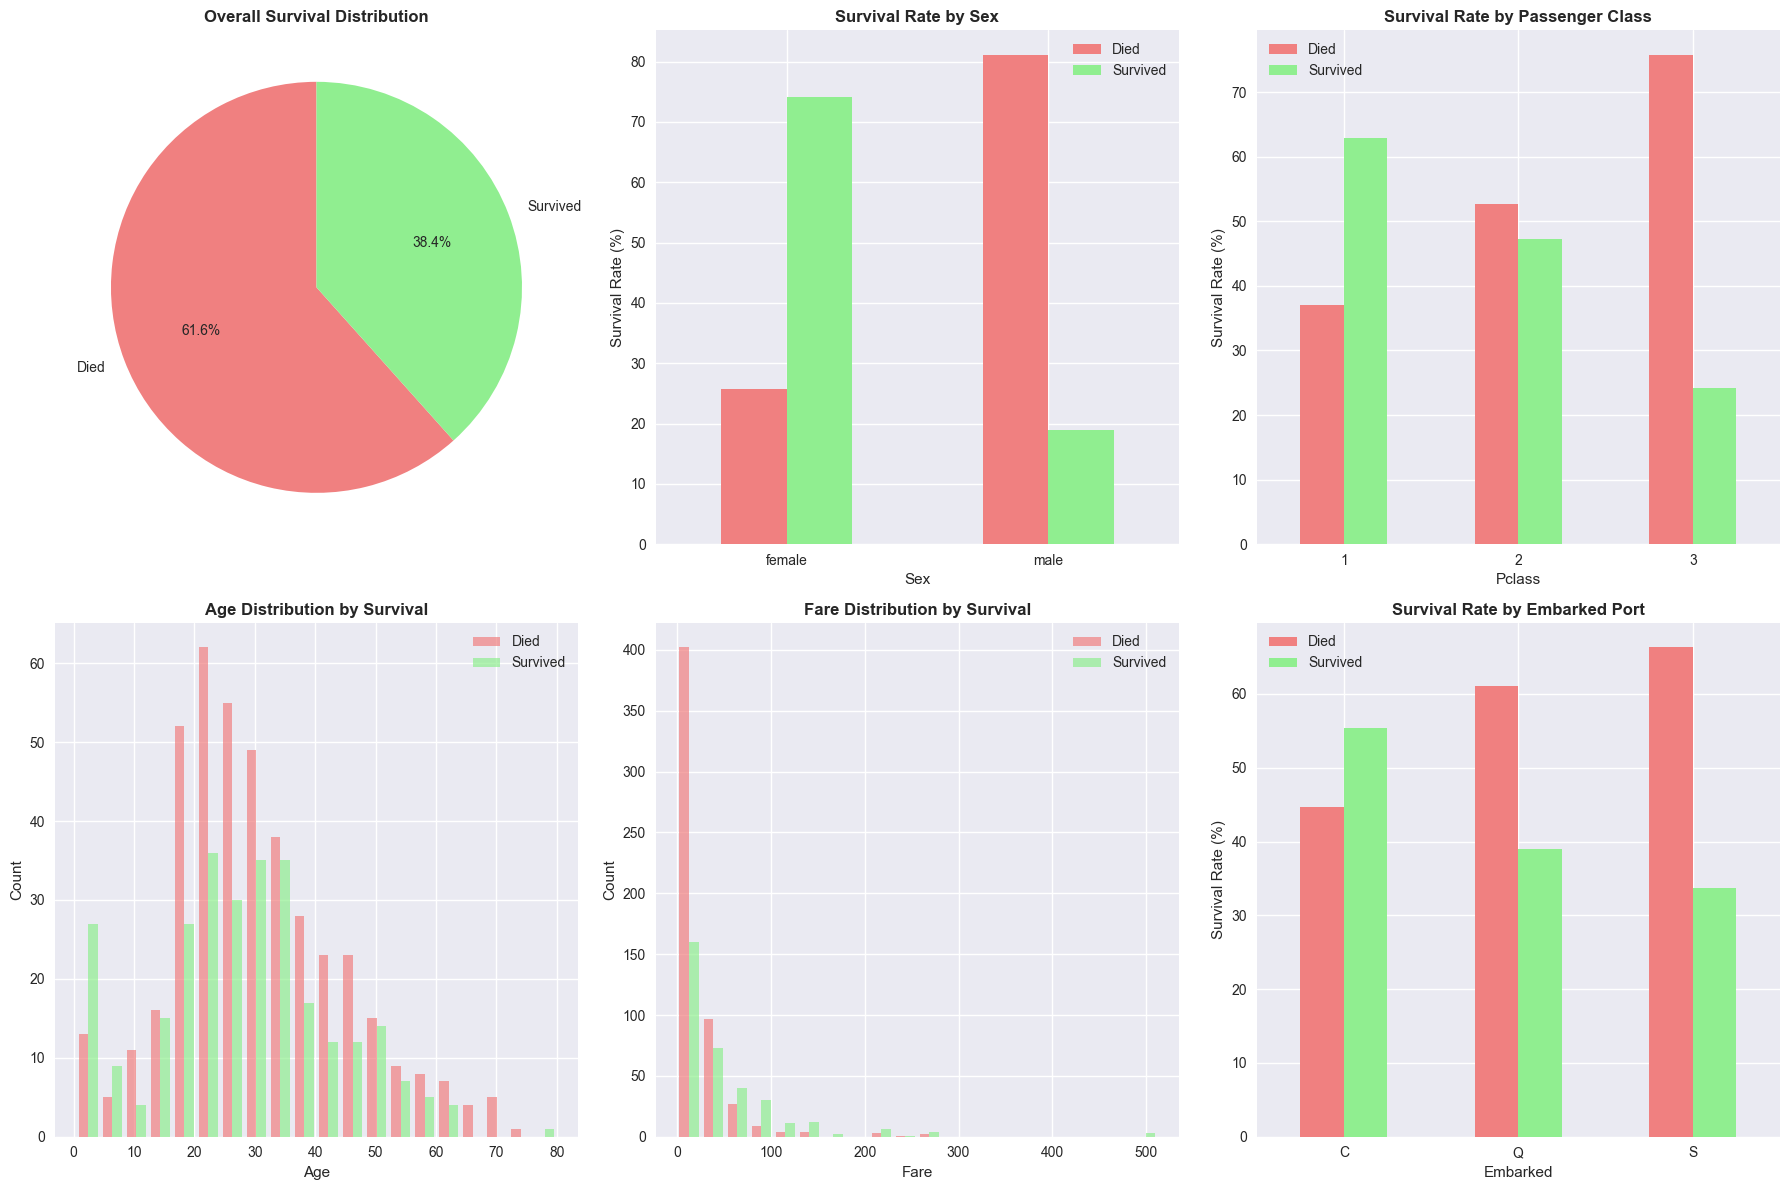

=== Key Survival Insights ===
Female survival rate: 74.2%
Male survival rate: 18.9%
1st class survival rate: 63.0%
2nd class survival rate: 47.3%
3rd class survival rate: 24.2%
Average age of survivors: 28.3 years
Average age of non-survivors: 30.6 years


In [5]:
# Visualize survival patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Survival distribution
survival_counts = train_data['Survived'].value_counts()
axes[0, 0].pie(survival_counts.values, labels=['Died', 'Survived'], autopct='%1.1f%%', 
              colors=['lightcoral', 'lightgreen'], startangle=90)
axes[0, 0].set_title('Overall Survival Distribution', fontweight='bold')

# 2. Survival by Sex
sex_survival = pd.crosstab(train_data['Sex'], train_data['Survived'], normalize='index') * 100
sex_survival.plot(kind='bar', ax=axes[0, 1], color=['lightcoral', 'lightgreen'])
axes[0, 1].set_title('Survival Rate by Sex', fontweight='bold')
axes[0, 1].set_ylabel('Survival Rate (%)')
axes[0, 1].legend(['Died', 'Survived'])
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Survival by Passenger Class
class_survival = pd.crosstab(train_data['Pclass'], train_data['Survived'], normalize='index') * 100
class_survival.plot(kind='bar', ax=axes[0, 2], color=['lightcoral', 'lightgreen'])
axes[0, 2].set_title('Survival Rate by Passenger Class', fontweight='bold')
axes[0, 2].set_ylabel('Survival Rate (%)')
axes[0, 2].legend(['Died', 'Survived'])
axes[0, 2].tick_params(axis='x', rotation=0)

# 4. Age distribution by survival
axes[1, 0].hist([train_data[train_data['Survived']==0]['Age'].dropna(), 
                train_data[train_data['Survived']==1]['Age'].dropna()], 
               bins=20, alpha=0.7, label=['Died', 'Survived'], color=['lightcoral', 'lightgreen'])
axes[1, 0].set_title('Age Distribution by Survival', fontweight='bold')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# 5. Fare distribution by survival
axes[1, 1].hist([train_data[train_data['Survived']==0]['Fare'].dropna(), 
                train_data[train_data['Survived']==1]['Fare'].dropna()], 
               bins=20, alpha=0.7, label=['Died', 'Survived'], color=['lightcoral', 'lightgreen'])
axes[1, 1].set_title('Fare Distribution by Survival', fontweight='bold')
axes[1, 1].set_xlabel('Fare')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

# 6. Embarked port survival
embarked_survival = pd.crosstab(train_data['Embarked'], train_data['Survived'], normalize='index') * 100
embarked_survival.plot(kind='bar', ax=axes[1, 2], color=['lightcoral', 'lightgreen'])
axes[1, 2].set_title('Survival Rate by Embarked Port', fontweight='bold')
axes[1, 2].set_ylabel('Survival Rate (%)')
axes[1, 2].legend(['Died', 'Survived'])
axes[1, 2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Print key insights
print("=== Key Survival Insights ===")
print(f"Female survival rate: {train_data[train_data['Sex']=='female']['Survived'].mean()*100:.1f}%")
print(f"Male survival rate: {train_data[train_data['Sex']=='male']['Survived'].mean()*100:.1f}%")
print(f"1st class survival rate: {train_data[train_data['Pclass']==1]['Survived'].mean()*100:.1f}%")
print(f"2nd class survival rate: {train_data[train_data['Pclass']==2]['Survived'].mean()*100:.1f}%")
print(f"3rd class survival rate: {train_data[train_data['Pclass']==3]['Survived'].mean()*100:.1f}%")
print(f"Average age of survivors: {train_data[train_data['Survived']==1]['Age'].mean():.1f} years")
print(f"Average age of non-survivors: {train_data[train_data['Survived']==0]['Age'].mean():.1f} years")


## 2. Data Preprocessing and Feature Engineering


In [6]:
# Create a copy of training data for preprocessing
df = train_data.copy()

print("=== Data Preprocessing ===")
print(f"Starting with {len(df)} samples and {len(df.columns)} features")

# 1. Handle missing values
print("\n1. Handling Missing Values:")

# Age: Fill with median age by passenger class and sex
print("   - Age: Filling missing values with median by Pclass and Sex")
age_median = df.groupby(['Pclass', 'Sex'])['Age'].median()
for pclass in df['Pclass'].unique():
    for sex in df['Sex'].unique():
        mask = (df['Pclass'] == pclass) & (df['Sex'] == sex) & (df['Age'].isnull())
        if mask.sum() > 0:
            median_age = age_median.loc[(pclass, sex)]
            df.loc[mask, 'Age'] = median_age
            print(f"     Filled {mask.sum()} missing ages for Pclass={pclass}, Sex={sex} with {median_age:.1f}")

# Embarked: Fill with most common port
print("   - Embarked: Filling missing values with mode")
embarked_mode = df['Embarked'].mode()[0]
embarked_missing = df['Embarked'].isnull().sum()
df['Embarked'].fillna(embarked_mode, inplace=True)
print(f"     Filled {embarked_missing} missing embarked values with '{embarked_mode}'")

# Fare: Fill with median fare by passenger class (for test set)
print("   - Fare: Ready to fill with median by Pclass if needed")

print(f"\nMissing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])


=== Data Preprocessing ===
Starting with 891 samples and 12 features

1. Handling Missing Values:
   - Age: Filling missing values with median by Pclass and Sex
     Filled 94 missing ages for Pclass=3, Sex=male with 25.0
     Filled 42 missing ages for Pclass=3, Sex=female with 21.5
     Filled 21 missing ages for Pclass=1, Sex=male with 40.0
     Filled 9 missing ages for Pclass=1, Sex=female with 35.0
     Filled 9 missing ages for Pclass=2, Sex=male with 30.0
     Filled 2 missing ages for Pclass=2, Sex=female with 28.0
   - Embarked: Filling missing values with mode
     Filled 2 missing embarked values with 'S'
   - Fare: Ready to fill with median by Pclass if needed

Missing values after imputation:
Cabin    687
dtype: int64


In [7]:
# 2. Feature Engineering
print("\n2. Feature Engineering:")

# Extract title from name
print("   - Creating Title feature from Name")
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_counts = df['Title'].value_counts()
print(f"     Found {len(title_counts)} unique titles")

# Group rare titles
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Other')
print(f"     Grouped {len(rare_titles)} rare titles into 'Other'")
print(f"     Final titles: {sorted(df['Title'].unique())}")

# Create family size feature
print("   - Creating FamilySize feature")
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
print(f"     Family sizes range from {df['FamilySize'].min()} to {df['FamilySize'].max()}")

# Create family size categories
print("   - Creating FamilyType feature")
df['FamilyType'] = 'Medium'
df.loc[df['FamilySize'] == 1, 'FamilyType'] = 'Single'
df.loc[df['FamilySize'] >= 5, 'FamilyType'] = 'Large'
family_type_counts = df['FamilyType'].value_counts()
print(f"     Family types: {dict(family_type_counts)}")

# Create age groups
print("   - Creating AgeGroup feature")
df['AgeGroup'] = 'Adult'
df.loc[df['Age'] <= 12, 'AgeGroup'] = 'Child'
df.loc[df['Age'] >= 60, 'AgeGroup'] = 'Senior'
age_group_counts = df['AgeGroup'].value_counts()
print(f"     Age groups: {dict(age_group_counts)}")

# Create fare categories
print("   - Creating FareGroup feature")
df['FareGroup'] = pd.cut(df['Fare'], bins=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])
fare_group_counts = df['FareGroup'].value_counts()
print(f"     Fare groups: {dict(fare_group_counts)}")

# Create deck feature from cabin
print("   - Creating Deck feature from Cabin")
df['Deck'] = df['Cabin'].str[0]
df['Deck'].fillna('Unknown', inplace=True)
deck_counts = df['Deck'].value_counts()
print(f"     Deck distribution: {dict(deck_counts)}")

print(f"\nFeatures after engineering: {len(df.columns)}")
print(f"New features created: Title, FamilySize, FamilyType, AgeGroup, FareGroup, Deck")



2. Feature Engineering:
   - Creating Title feature from Name
     Found 17 unique titles
     Grouped 13 rare titles into 'Other'
     Final titles: ['Master', 'Miss', 'Mr', 'Mrs', 'Other']
   - Creating FamilySize feature
     Family sizes range from 1 to 11
   - Creating FamilyType feature
     Family types: {'Single': np.int64(537), 'Medium': np.int64(292), 'Large': np.int64(62)}
   - Creating AgeGroup feature
     Age groups: {'Adult': np.int64(796), 'Child': np.int64(69), 'Senior': np.int64(26)}
   - Creating FareGroup feature
     Fare groups: {'Low': np.int64(853), 'Medium': np.int64(29), 'High': np.int64(6), 'VeryHigh': np.int64(3)}
   - Creating Deck feature from Cabin
     Deck distribution: {'Unknown': np.int64(687), 'C': np.int64(59), 'B': np.int64(47), 'D': np.int64(33), 'E': np.int64(32), 'A': np.int64(15), 'F': np.int64(13), 'G': np.int64(4), 'T': np.int64(1)}

Features after engineering: 18
New features created: Title, FamilySize, FamilyType, AgeGroup, FareGroup, Deck

In [8]:
# 3. Select and encode features for modeling
print("\n3. Feature Selection and Encoding:")

# Select relevant features for the decision tree
selected_features = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
    'Title', 'FamilySize', 'FamilyType', 'AgeGroup', 'FareGroup', 'Deck'
]

print(f"Selected features for modeling: {len(selected_features)}")
for feature in selected_features:
    print(f"  - {feature}")

# Create feature matrix
X = df[selected_features].copy()
y = df['Survived'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical features: {len(categorical_cols)}")
print(f"Numerical features: {len(numerical_cols)}")

# Apply label encoding to categorical features
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} classes")

print(f"\nFinal encoded feature matrix shape: {X_encoded.shape}")
print(f"All features are now numerical")

# Display sample of encoded data
print(f"\nSample of encoded features:")
X_encoded.head()



3. Feature Selection and Encoding:
Selected features for modeling: 13
  - Pclass
  - Sex
  - Age
  - SibSp
  - Parch
  - Fare
  - Embarked
  - Title
  - FamilySize
  - FamilyType
  - AgeGroup
  - FareGroup
  - Deck

Feature matrix shape: (891, 13)
Target vector shape: (891,)

Categorical features: 7
Numerical features: 6
Encoded Sex: 2 classes
Encoded Embarked: 3 classes
Encoded Title: 5 classes
Encoded FamilyType: 3 classes
Encoded AgeGroup: 3 classes
Encoded FareGroup: 4 classes
Encoded Deck: 9 classes

Final encoded feature matrix shape: (891, 13)
All features are now numerical

Sample of encoded features:


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,FamilyType,AgeGroup,FareGroup,Deck
0,3,1,22.0,1,0,7.2500,2,2,2,1,0,1,8
1,1,0,38.0,1,0,71.2833,0,3,2,1,0,1,2
2,3,0,26.0,0,0,7.9250,2,1,1,2,0,1,8
3,1,0,35.0,1,0,53.1000,2,3,2,1,0,1,2
4,3,1,35.0,0,0,8.0500,2,2,1,2,0,1,8


## 3. Train-Test Split


In [9]:
# Split the data into training and validation sets
print("=== Train-Test Split ===")

X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, 
    test_size=0.2,          # 80% train, 20% validation
    random_state=42,        # For reproducibility
    stratify=y              # Maintain survival distribution in both sets
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Training set percentage: {X_train.shape[0] / len(X_encoded) * 100:.1f}%")
print(f"Validation set percentage: {X_val.shape[0] / len(X_encoded) * 100:.1f}%")

print(f"\nSurvival distribution in training set:")
train_survival_dist = y_train.value_counts()
print(f"Died (0): {train_survival_dist[0]} ({train_survival_dist[0]/len(y_train)*100:.1f}%)")
print(f"Survived (1): {train_survival_dist[1]} ({train_survival_dist[1]/len(y_train)*100:.1f}%)")

print(f"\nSurvival distribution in validation set:")
val_survival_dist = y_val.value_counts()
print(f"Died (0): {val_survival_dist[0]} ({val_survival_dist[0]/len(y_val)*100:.1f}%)")
print(f"Survived (1): {val_survival_dist[1]} ({val_survival_dist[1]/len(y_val)*100:.1f}%)")

print(f"\nFeature matrix shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

print(f"\nData is ready for Decision Tree training!")


=== Train-Test Split ===
Training set size: 712 samples
Validation set size: 179 samples
Training set percentage: 79.9%
Validation set percentage: 20.1%

Survival distribution in training set:
Died (0): 439 (61.7%)
Survived (1): 273 (38.3%)

Survival distribution in validation set:
Died (0): 110 (61.5%)
Survived (1): 69 (38.5%)

Feature matrix shapes:
X_train: (712, 13)
X_val: (179, 13)
y_train: (712,)
y_val: (179,)

Data is ready for Decision Tree training!


## 4. Decision Tree Model Building and Training


In [10]:
# Initialize and train the Decision Tree model
print("=== Decision Tree Model Training ===")

# Initialize Decision Tree with reasonable parameters
dt_model = DecisionTreeClassifier(
    criterion='gini',           # Splitting criterion (gini or entropy)
    max_depth=5,               # Maximum depth to prevent overfitting
    min_samples_split=20,      # Minimum samples required to split
    min_samples_leaf=10,       # Minimum samples required at leaf node
    max_features='sqrt',       # Number of features to consider for best split
    random_state=42,           # For reproducibility
    class_weight=None          # No class weighting (dataset is reasonably balanced)
)

print("Model parameters:")
for param, value in dt_model.get_params().items():
    print(f"  {param}: {value}")
print()

# Train the model
print("Training the Decision Tree model...")
import time
start_time = time.time()

dt_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.3f} seconds")
print(f"Tree depth: {dt_model.tree_.max_depth}")
print(f"Number of leaves: {dt_model.tree_.n_leaves}")
print(f"Number of nodes: {dt_model.tree_.node_count}")
print(f"Number of features used: {dt_model.n_features_in_}")

# Display feature names for reference
feature_names = X_encoded.columns.tolist()
print(f"Feature names: {feature_names[:5]}...") # Show first 5


=== Decision Tree Model Training ===
Model parameters:
  ccp_alpha: 0.0
  class_weight: None
  criterion: gini
  max_depth: 5
  max_features: sqrt
  max_leaf_nodes: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 10
  min_samples_split: 20
  min_weight_fraction_leaf: 0.0
  monotonic_cst: None
  random_state: 42
  splitter: best

Training the Decision Tree model...
Training completed in 0.006 seconds
Tree depth: 5
Number of leaves: 13
Number of nodes: 25
Number of features used: 13
Feature names: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']...


In [11]:
# Make predictions on both training and validation sets
print("=== Making Predictions ===")

# Training set predictions
y_train_pred = dt_model.predict(X_train)
y_train_pred_proba = dt_model.predict_proba(X_train)

# Validation set predictions
y_val_pred = dt_model.predict(X_val)
y_val_pred_proba = dt_model.predict_proba(X_val)

print(f"Training predictions shape: {y_train_pred.shape}")
print(f"Validation predictions shape: {y_val_pred.shape}")
print(f"Training prediction probabilities shape: {y_train_pred_proba.shape}")
print(f"Validation prediction probabilities shape: {y_val_pred_proba.shape}")

# Display sample predictions with confidence
print(f"\nFirst 10 validation predictions vs actual:")
for i in range(10):
    actual = "Survived" if y_val.iloc[i] == 1 else "Died"
    predicted = "Survived" if y_val_pred[i] == 1 else "Died"
    confidence = max(y_val_pred_proba[i]) * 100
    print(f"Passenger {i+1}: Actual={actual}, Predicted={predicted}, Confidence={confidence:.1f}%")

# Show prediction distribution
print(f"\nPrediction distribution on validation set:")
val_pred_counts = pd.Series(y_val_pred).value_counts()
print(f"Predicted Died (0): {val_pred_counts[0]} ({val_pred_counts[0]/len(y_val_pred)*100:.1f}%)")
print(f"Predicted Survived (1): {val_pred_counts[1]} ({val_pred_counts[1]/len(y_val_pred)*100:.1f}%)")


=== Making Predictions ===
Training predictions shape: (712,)
Validation predictions shape: (179,)
Training prediction probabilities shape: (712, 2)
Validation prediction probabilities shape: (179, 2)

First 10 validation predictions vs actual:
Passenger 1: Actual=Died, Predicted=Died, Confidence=65.7%
Passenger 2: Actual=Died, Predicted=Died, Confidence=65.7%
Passenger 3: Actual=Survived, Predicted=Died, Confidence=89.7%
Passenger 4: Actual=Died, Predicted=Died, Confidence=65.7%
Passenger 5: Actual=Survived, Predicted=Died, Confidence=65.7%
Passenger 6: Actual=Survived, Predicted=Died, Confidence=65.7%
Passenger 7: Actual=Survived, Predicted=Died, Confidence=65.7%
Passenger 8: Actual=Died, Predicted=Survived, Confidence=60.4%
Passenger 9: Actual=Died, Predicted=Survived, Confidence=79.5%
Passenger 10: Actual=Died, Predicted=Died, Confidence=65.7%

Prediction distribution on validation set:
Predicted Died (0): 124 (69.3%)
Predicted Survived (1): 55 (30.7%)


## 5. Model Evaluation and Performance Metrics


In [12]:
# Calculate comprehensive performance metrics
print("=== Model Performance Metrics ===")

# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred_proba[:, 1])

# Validation set metrics  
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_pred_proba[:, 1])

print("TRAINING SET PERFORMANCE:")
print(f"Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-Score:  {train_f1:.4f}")
print(f"AUC-ROC:   {train_auc:.4f}")
print()

print("VALIDATION SET PERFORMANCE:")
print(f"Accuracy:  {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1-Score:  {val_f1:.4f}")
print(f"AUC-ROC:   {val_auc:.4f}")
print()

# Check for overfitting
accuracy_diff = train_accuracy - val_accuracy
print(f"OVERFITTING CHECK:")
print(f"Training-Validation Accuracy Difference: {accuracy_diff:.4f} ({accuracy_diff*100:.2f}%)")
if accuracy_diff > 0.05:
    print("WARNING: Model may be overfitting (>5% difference)")
elif accuracy_diff > 0.02:
    print("WARNING: Slight overfitting detected (2-5% difference)")
else:
    print("GOOD: No significant overfitting detected (<2% difference)")

# Survival prediction performance
print(f"\nSURVIVAL PREDICTION ANALYSIS:")
print(f"Baseline survival rate: {y_train.mean()*100:.1f}%")
print(f"Model predicted survival rate: {y_val_pred.mean()*100:.1f}%")
print(f"Actual validation survival rate: {y_val.mean()*100:.1f}%")


=== Model Performance Metrics ===
TRAINING SET PERFORMANCE:
Accuracy:  0.7612 (76.12%)
Precision: 0.7249
Recall:    0.6081
F1-Score:  0.6614
AUC-ROC:   0.8183

VALIDATION SET PERFORMANCE:
Accuracy:  0.6425 (64.25%)
Precision: 0.5455
Recall:    0.4348
F1-Score:  0.4839
AUC-ROC:   0.7090

OVERFITTING CHECK:
Training-Validation Accuracy Difference: 0.1188 (11.88%)

SURVIVAL PREDICTION ANALYSIS:
Baseline survival rate: 38.3%
Model predicted survival rate: 30.7%
Actual validation survival rate: 38.5%


In [13]:
# Detailed classification report
print("=== Detailed Classification Report ===")
print("\nTRAINING SET:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Died', 'Survived'], 
                          digits=4))

print("\nVALIDATION SET:")
print(classification_report(y_val, y_val_pred, 
                          target_names=['Died', 'Survived'], 
                          digits=4))


=== Detailed Classification Report ===

TRAINING SET:
              precision    recall  f1-score   support

        Died     0.7785    0.8565    0.8156       439
    Survived     0.7249    0.6081    0.6614       273

    accuracy                         0.7612       712
   macro avg     0.7517    0.7323    0.7385       712
weighted avg     0.7579    0.7612    0.7565       712


VALIDATION SET:
              precision    recall  f1-score   support

        Died     0.6855    0.7727    0.7265       110
    Survived     0.5455    0.4348    0.4839        69

    accuracy                         0.6425       179
   macro avg     0.6155    0.6038    0.6052       179
weighted avg     0.6315    0.6425    0.6330       179



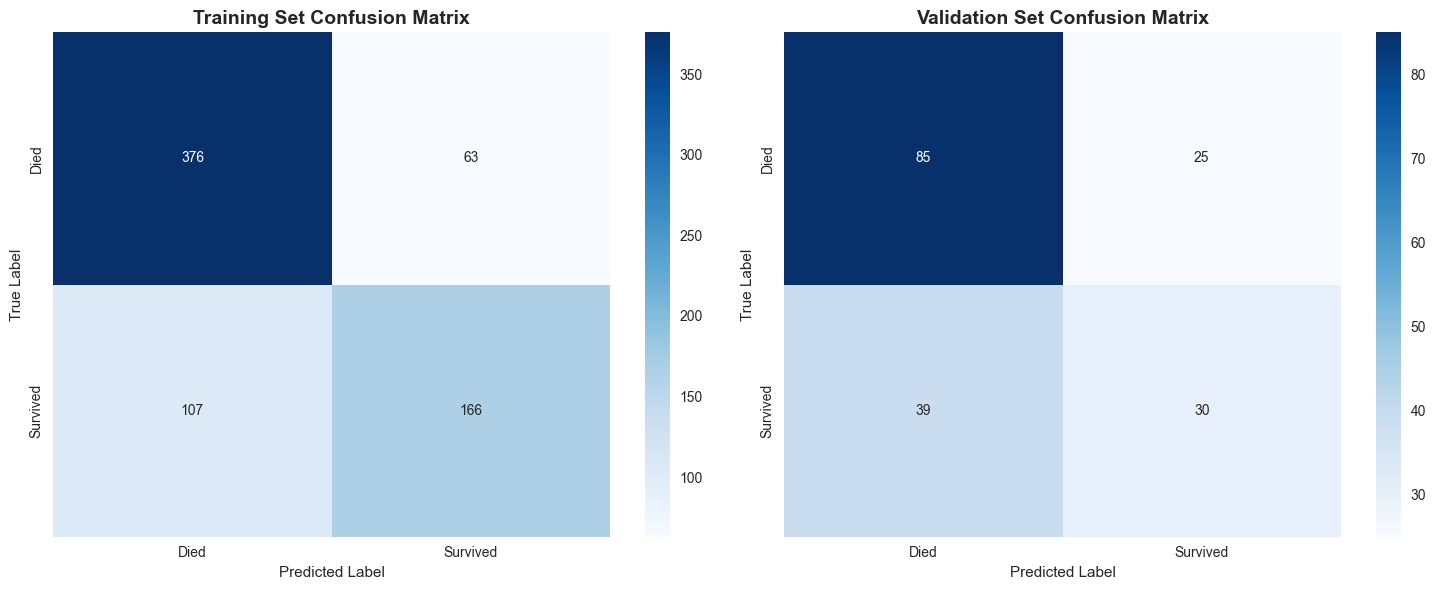

=== Confusion Matrix Interpretation ===
Validation Set Results:
True Negatives (Correctly predicted Died): 85
False Positives (Wrongly predicted Survived): 25
False Negatives (Wrongly predicted Died): 39
True Positives (Correctly predicted Survived): 30

Model Performance:
Correctly identified survivors: 30/69 (43.5%)
Correctly identified non-survivors: 85/110 (77.3%)
Overall accuracy: 64.2%


In [14]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set confusion matrix
train_cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Died', 'Survived'], 
           yticklabels=['Died', 'Survived'], ax=axes[0])
axes[0].set_title('Training Set Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Validation set confusion matrix
val_cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Died', 'Survived'], 
           yticklabels=['Died', 'Survived'], ax=axes[1])
axes[1].set_title('Validation Set Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print confusion matrix interpretation
print("=== Confusion Matrix Interpretation ===")
print("Validation Set Results:")
tn, fp, fn, tp = val_cm.ravel()
print(f"True Negatives (Correctly predicted Died): {tn}")
print(f"False Positives (Wrongly predicted Survived): {fp}")
print(f"False Negatives (Wrongly predicted Died): {fn}")
print(f"True Positives (Correctly predicted Survived): {tp}")
print()
print(f"Model Performance:")
print(f"Correctly identified survivors: {tp}/{tp+fn} ({tp/(tp+fn)*100:.1f}%)")
print(f"Correctly identified non-survivors: {tn}/{tn+fp} ({tn/(tn+fp)*100:.1f}%)")
print(f"Overall accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:.1f}%")


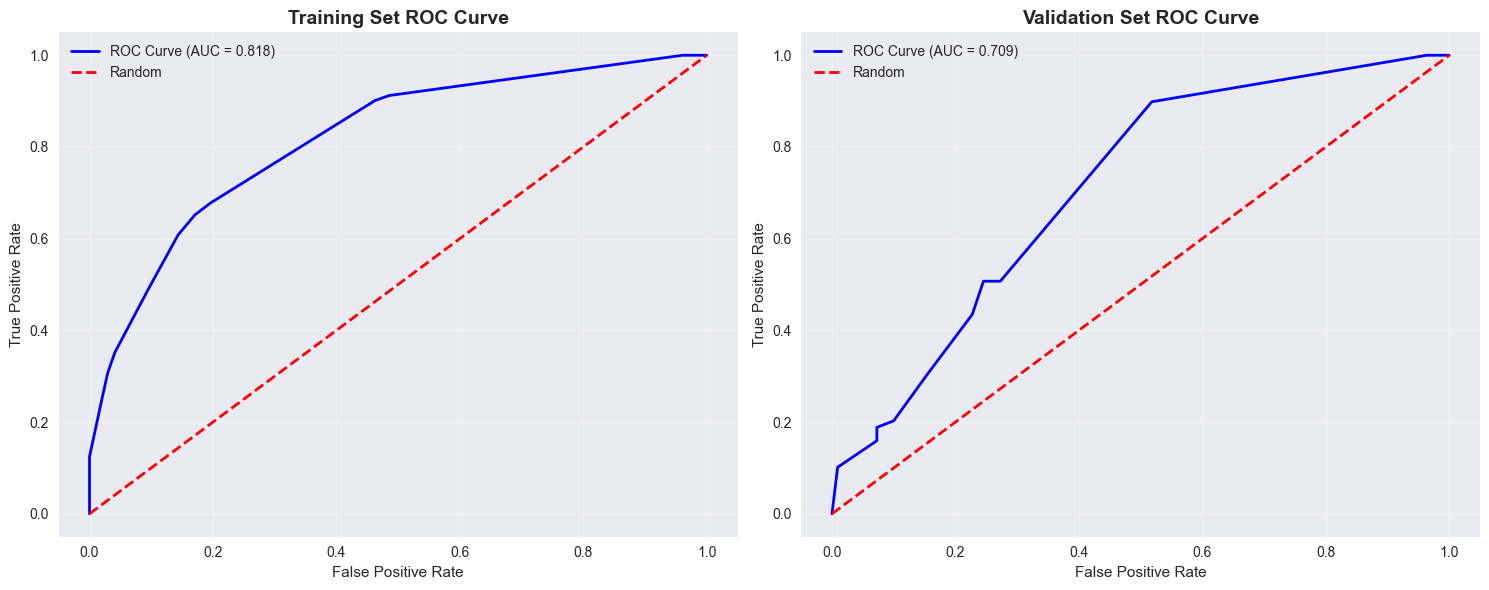

=== ROC-AUC Interpretation ===
Training AUC: 0.8183
Validation AUC: 0.7090

FAIR: Fair model performance (AUC ≥ 0.70)

The model can distinguish between survivors and non-survivors
with 70.9% effectiveness (50% = random, 100% = perfect)


In [15]:
# ROC Curve Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba[:, 1])
axes[0].plot(fpr_train, tpr_train, color='blue', lw=2, 
            label=f'ROC Curve (AUC = {train_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Training Set ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set ROC curve
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba[:, 1])
axes[1].plot(fpr_val, tpr_val, color='blue', lw=2, 
            label=f'ROC Curve (AUC = {val_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Validation Set ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== ROC-AUC Interpretation ===")
print(f"Training AUC: {train_auc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print()
if val_auc >= 0.90:
    print("EXCELLENT: Excellent model performance (AUC ≥ 0.90)")
elif val_auc >= 0.80:
    print("GOOD: Good model performance (AUC ≥ 0.80)")
elif val_auc >= 0.70:
    print("FAIR: Fair model performance (AUC ≥ 0.70)")
else:
    print("POOR: Poor model performance (AUC < 0.70)")

print(f"\nThe model can distinguish between survivors and non-survivors")
print(f"with {val_auc*100:.1f}% effectiveness (50% = random, 100% = perfect)")


## 6. Decision Tree Visualization


=== Decision Tree Visualization ===


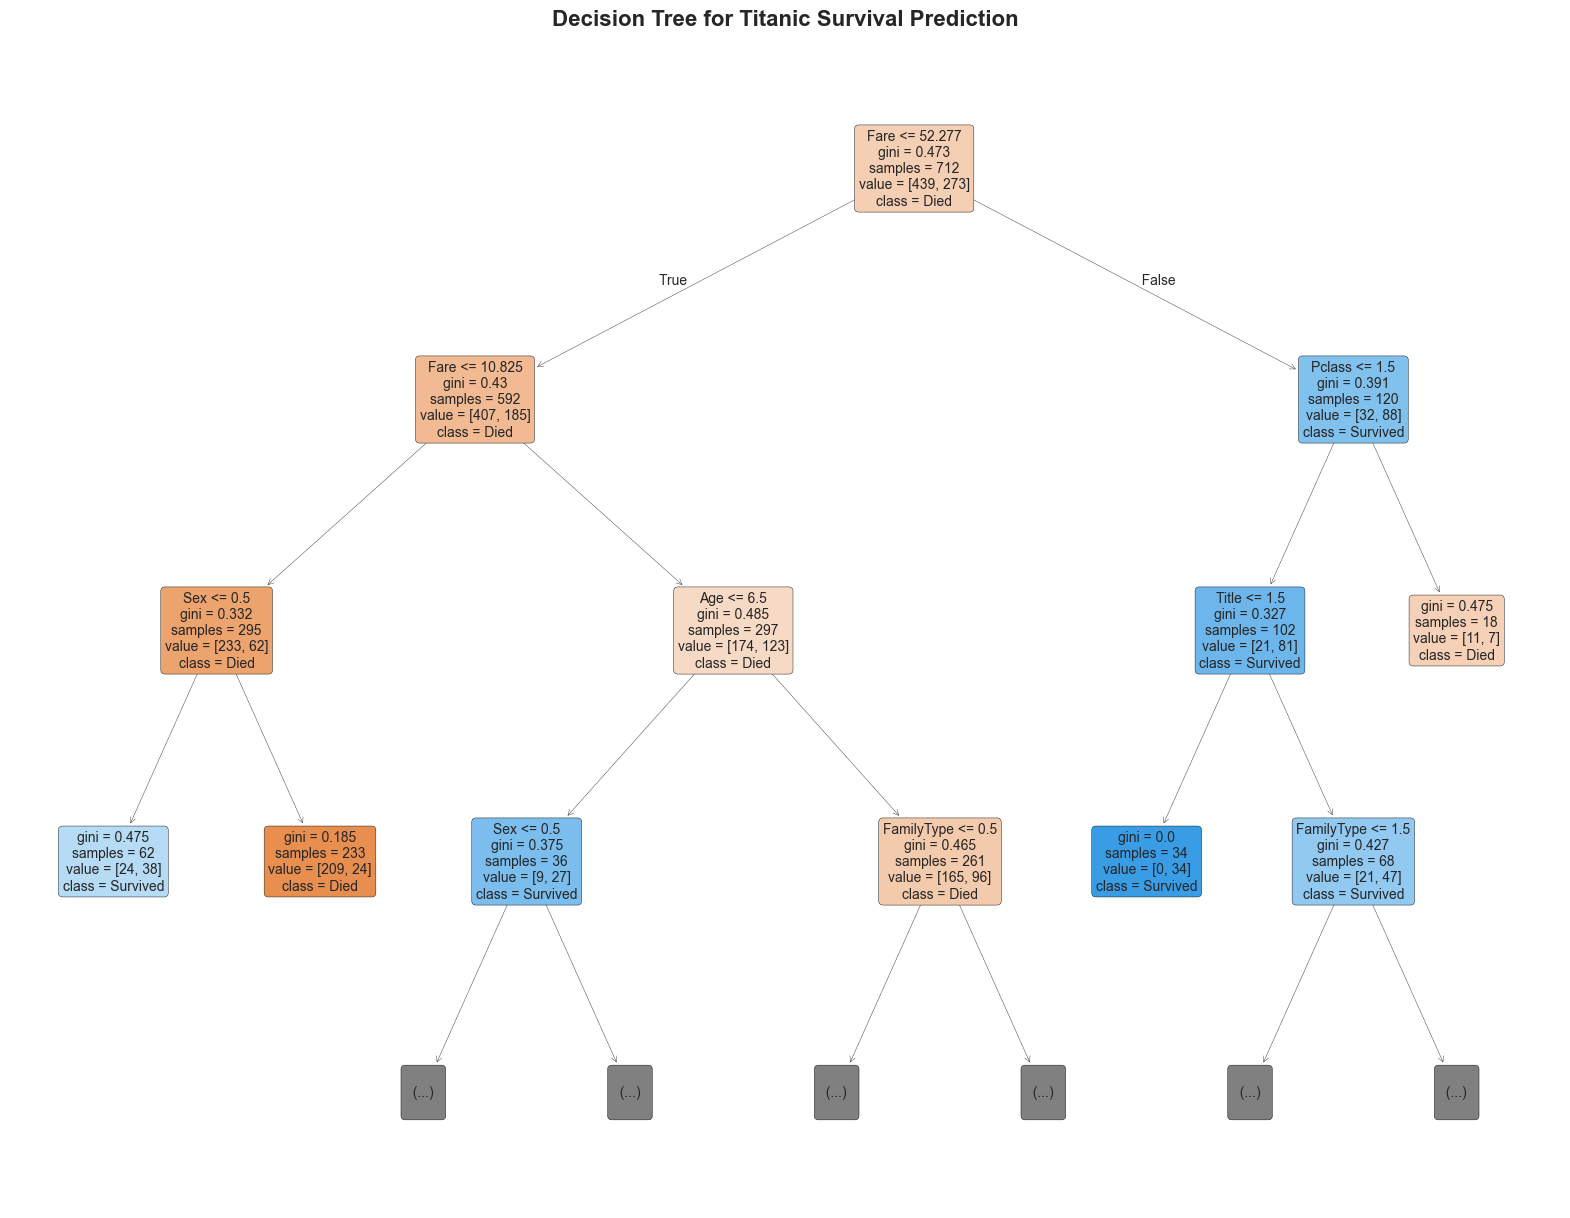

Tree visualization shows the decision paths:
- Root node represents the entire dataset
- Each internal node shows a decision rule
- Leaf nodes show the final prediction
- Colors indicate class: Orange = Died, Blue = Survived
- 'samples' = number of training samples in that node
- 'value' = [died_count, survived_count] in that node


In [16]:
# Visualize the Decision Tree
print("=== Decision Tree Visualization ===")

# Create a large figure for the tree
plt.figure(figsize=(20, 15))

# Plot the decision tree
plot_tree(dt_model, 
          feature_names=feature_names,
          class_names=['Died', 'Survived'],
          filled=True,                    # Fill nodes with colors
          rounded=True,                   # Round the corners
          fontsize=10,                    # Font size for readability
          max_depth=3)                    # Limit depth for readability

plt.title('Decision Tree for Titanic Survival Prediction', fontsize=16, fontweight='bold', pad=20)
plt.show()

print(f"Tree visualization shows the decision paths:")
print(f"- Root node represents the entire dataset")
print(f"- Each internal node shows a decision rule")
print(f"- Leaf nodes show the final prediction")
print(f"- Colors indicate class: Orange = Died, Blue = Survived")
print(f"- 'samples' = number of training samples in that node")
print(f"- 'value' = [died_count, survived_count] in that node")


In [17]:
# Text representation of the decision tree
print("=== Decision Tree Rules (Text Format) ===")

# Get text representation of the tree
tree_rules = export_text(dt_model, 
                        feature_names=feature_names,
                        class_names=['Died', 'Survived'],
                        max_depth=4)

print("Decision Tree Rules:")
print(tree_rules)

print("\n=== How to Read the Tree Rules ===")
print("1. Start at the root (top)")
print("2. Follow the conditions down the tree")
print("3. Each '|' represents a level in the tree")
print("4. 'class:' shows the final prediction")
print("5. Numbers in brackets show [died_samples, survived_samples]")
print("\nExample interpretation:")
print("- If Sex <= 0.5 (Female) → Higher survival chance")
print("- If Sex > 0.5 (Male) → Lower survival chance")
print("- Further splits consider Pclass, Fare, Age, etc.")


=== Decision Tree Rules (Text Format) ===
Decision Tree Rules:
|--- Fare <= 52.28
|   |--- Fare <= 10.82
|   |   |--- Sex <= 0.50
|   |   |   |--- class: Survived
|   |   |--- Sex >  0.50
|   |   |   |--- class: Died
|   |--- Fare >  10.82
|   |   |--- Age <= 6.50
|   |   |   |--- Sex <= 0.50
|   |   |   |   |--- class: Survived
|   |   |   |--- Sex >  0.50
|   |   |   |   |--- class: Survived
|   |   |--- Age >  6.50
|   |   |   |--- FamilyType <= 0.50
|   |   |   |   |--- Parch <= 2.50
|   |   |   |   |   |--- class: Died
|   |   |   |   |--- Parch >  2.50
|   |   |   |   |   |--- class: Died
|   |   |   |--- FamilyType >  0.50
|   |   |   |   |--- Deck <= 6.50
|   |   |   |   |   |--- class: Survived
|   |   |   |   |--- Deck >  6.50
|   |   |   |   |   |--- class: Died
|--- Fare >  52.28
|   |--- Pclass <= 1.50
|   |   |--- Title <= 1.50
|   |   |   |--- class: Survived
|   |   |--- Title >  1.50
|   |   |   |--- FamilyType <= 1.50
|   |   |   |   |--- Age <= 49.50
|   |   |   |   

## 7. Feature Importance Analysis


In [18]:
# Extract and analyze feature importance
print("=== Feature Importance Analysis ===")

# Get feature importance from the trained model
feature_importance = dt_model.feature_importances_

# Create a dataframe for easier manipulation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance,
    'importance_pct': feature_importance * 100
}).sort_values('importance', ascending=False)

print("Feature Importance Ranking:")
print(importance_df.to_string(index=False))
print()

# Calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()

# Find features that contribute to 80% of total importance
features_80_percent = importance_df[importance_df['cumulative_importance'] <= 0.8]
print(f"Features contributing to 80% of importance: {len(features_80_percent)}")
if len(features_80_percent) > 0:
    print("These features are:")
    for _, row in features_80_percent.iterrows():
        print(f"  - {row['feature']}: {row['importance_pct']:.1f}%")

print(f"\nTop 3 Most Important Features:")
for i, (_, row) in enumerate(importance_df.head(3).iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance_pct']:.1f}% importance")

# Features with zero importance
zero_importance = importance_df[importance_df['importance'] == 0]
if len(zero_importance) > 0:
    print(f"\nFeatures with zero importance ({len(zero_importance)}):")
    print(zero_importance['feature'].tolist())
else:
    print(f"\nAll features contribute to the model (no zero importance features)")


=== Feature Importance Analysis ===
Feature Importance Ranking:
   feature  importance  importance_pct
      Fare    0.450597       45.059689
       Sex    0.241954       24.195445
       Age    0.104918       10.491757
FamilyType    0.054079        5.407903
      Deck    0.052641        5.264141
    Pclass    0.047511        4.751147
     Title    0.040880        4.088038
     Parch    0.007419        0.741879
     SibSp    0.000000        0.000000
  Embarked    0.000000        0.000000
FamilySize    0.000000        0.000000
  AgeGroup    0.000000        0.000000
 FareGroup    0.000000        0.000000

Features contributing to 80% of importance: 3
These features are:
  - Fare: 45.1%
  - Sex: 24.2%
  - Age: 10.5%

Top 3 Most Important Features:
1. Fare: 45.1% importance
2. Sex: 24.2% importance
3. Age: 10.5% importance

Features with zero importance (5):
['SibSp', 'Embarked', 'FamilySize', 'AgeGroup', 'FareGroup']


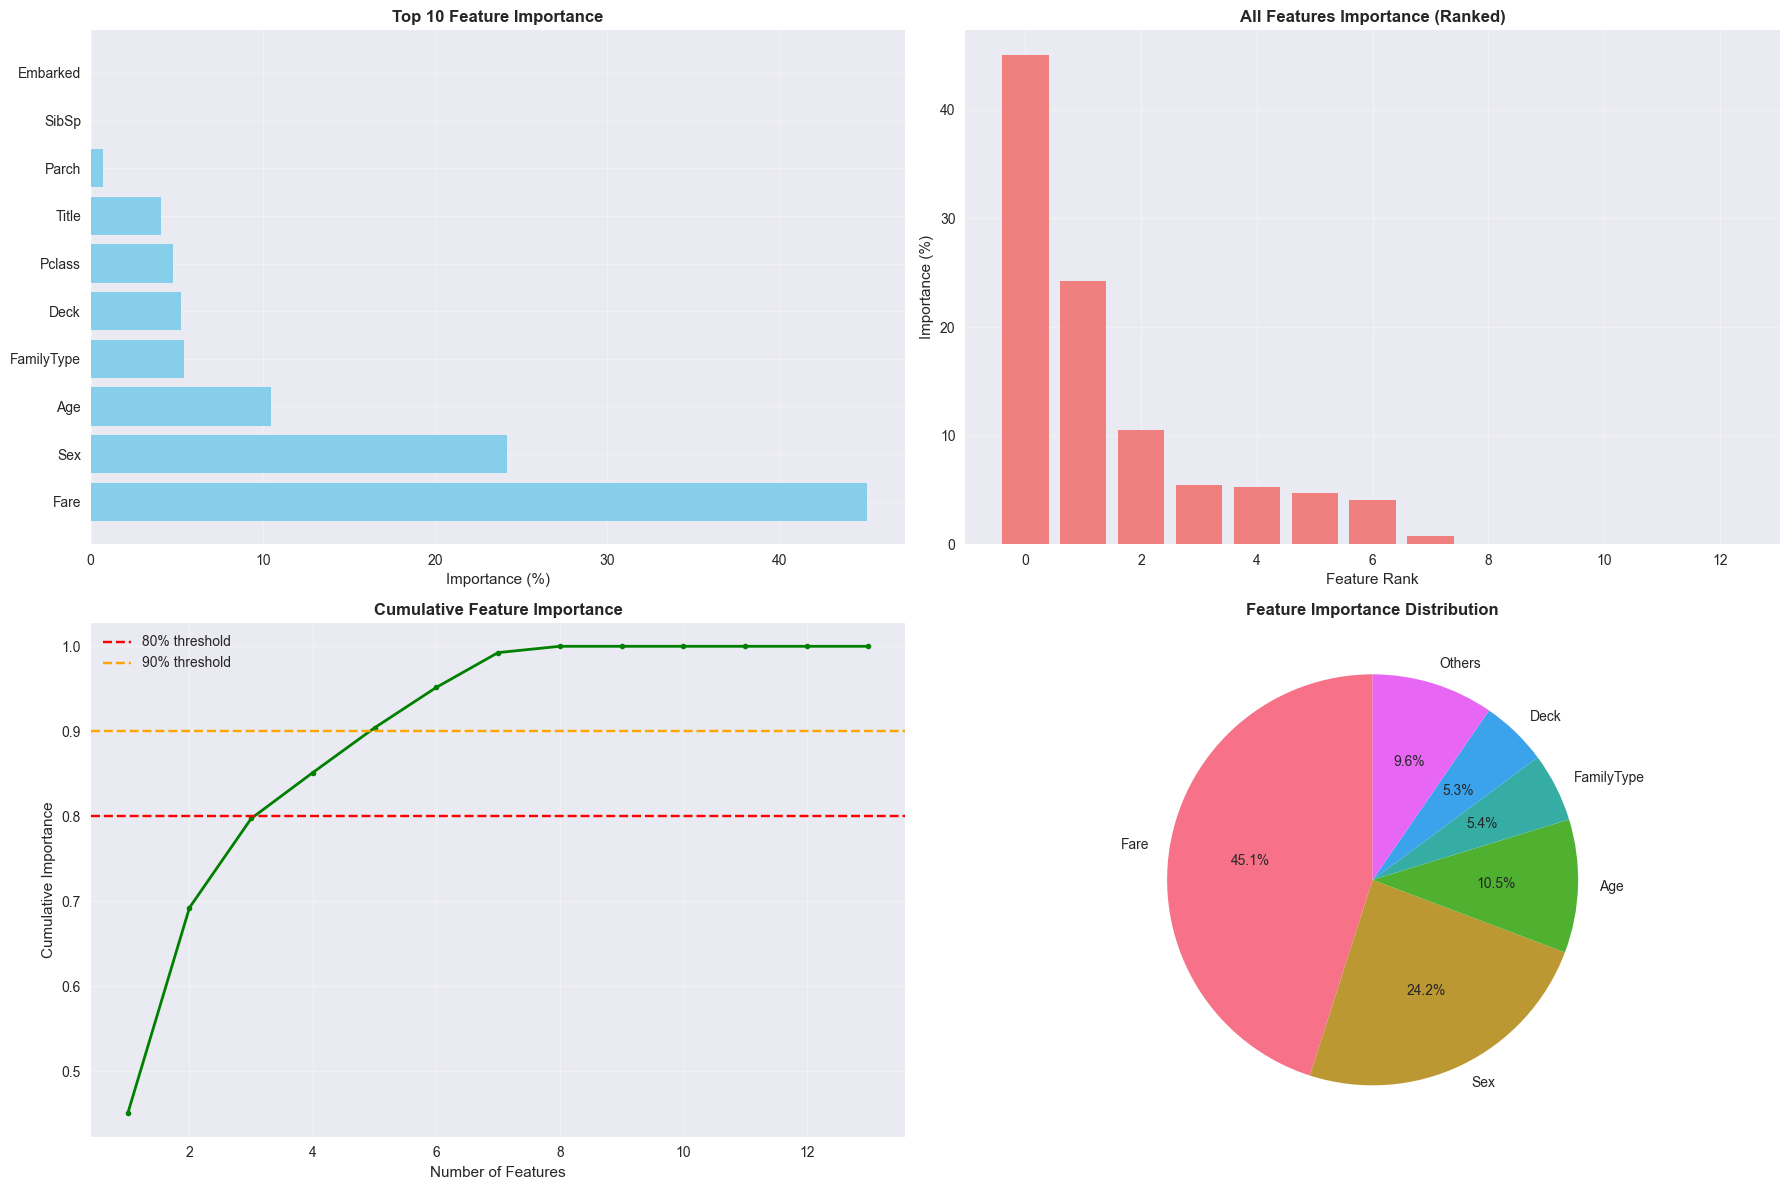

=== Feature Importance Interpretation ===
Total number of features: 13
Features with non-zero importance: 8
Mean importance: 0.0769
Standard deviation: 0.1308
Features needed for 50.0% of total importance: 1
Features needed for 80.0% of total importance: 3
Features needed for 90.0% of total importance: 4
Features needed for 95.0% of total importance: 5


In [19]:
# Visualize feature importance
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Horizontal bar plot of top features
top_features = importance_df.head(10)
axes[0, 0].barh(range(len(top_features)), top_features['importance_pct'], color='skyblue')
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'])
axes[0, 0].set_xlabel('Importance (%)')
axes[0, 0].set_title('Top 10 Feature Importance', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. All features importance (sorted)
axes[0, 1].bar(range(len(importance_df)), importance_df['importance_pct'], color='lightcoral')
axes[0, 1].set_xlabel('Feature Rank')
axes[0, 1].set_ylabel('Importance (%)')
axes[0, 1].set_title('All Features Importance (Ranked)', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Cumulative importance plot
axes[1, 0].plot(range(1, len(importance_df) + 1), importance_df['cumulative_importance'], 
               marker='o', linewidth=2, markersize=4, color='green')
axes[1, 0].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1, 0].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('Cumulative Importance')
axes[1, 0].set_title('Cumulative Feature Importance', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Pie chart of top 5 features
top_5 = importance_df.head(5)
others_importance = importance_df.iloc[5:]['importance'].sum()
pie_data = list(top_5['importance']) + [others_importance]
pie_labels = list(top_5['feature']) + ['Others']
axes[1, 1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Feature Importance Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

# Feature importance interpretation
print("=== Feature Importance Interpretation ===")
print(f"Total number of features: {len(importance_df)}")
print(f"Features with non-zero importance: {(importance_df['importance'] > 0).sum()}")
print(f"Mean importance: {importance_df['importance'].mean():.4f}")
print(f"Standard deviation: {importance_df['importance'].std():.4f}")

# Find how many features needed for different thresholds
for threshold in [0.5, 0.8, 0.9, 0.95]:
    n_features = len(importance_df[importance_df['cumulative_importance'] <= threshold])
    print(f"Features needed for {threshold*100}% of total importance: {n_features}")


## 8. Cross-Validation and Hyperparameter Tuning


In [20]:
# Perform cross-validation to assess model robustness
print("=== Cross-Validation Analysis ===")

# 5-fold cross-validation
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print(f"5-Fold Cross-Validation Results:")
print(f"Individual fold scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Min Score: {cv_scores.min():.4f}")
print(f"Max Score: {cv_scores.max():.4f}")
print()

# Cross-validation with different metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = {}

print("Cross-Validation Results for Multiple Metrics:")
for metric in metrics:
    scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring=metric, n_jobs=-1)
    cv_results[metric] = scores
    print(f"{metric.upper()}: {scores.mean():.4f} (±{scores.std() * 2:.4f})")

# Model stability assessment
print("\n=== Model Stability Assessment ===")
accuracy_std = cv_results['accuracy'].std()
if accuracy_std < 0.02:
    print("EXCELLENT: Excellent stability (std < 0.02)")
elif accuracy_std < 0.05:
    print("GOOD: Good stability (std < 0.05)")
elif accuracy_std < 0.10:
    print("MODERATE: Moderate stability (std < 0.10)")
else:
    print("POOR: Poor stability (std ≥ 0.10)")
print(f"Accuracy standard deviation: {accuracy_std:.4f}")


=== Cross-Validation Analysis ===
5-Fold Cross-Validation Results:
Individual fold scores: [0.72727273 0.75524476 0.8028169  0.72535211 0.76056338]
Mean CV Accuracy: 0.7542 (±0.0563)
Standard Deviation: 0.0282
Min Score: 0.7254
Max Score: 0.8028

Cross-Validation Results for Multiple Metrics:
ACCURACY: 0.7542 (±0.0563)
PRECISION: 0.7227 (±0.0384)
RECALL: 0.5785 (±0.1827)
F1: 0.6398 (±0.1208)
ROC_AUC: 0.7906 (±0.0390)

=== Model Stability Assessment ===
GOOD: Good stability (std < 0.05)
Accuracy standard deviation: 0.0282


In [21]:
# Hyperparameter tuning using GridSearchCV
print("=== Hyperparameter Tuning ===")
print("Performing grid search to find optimal hyperparameters...")

# Define parameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, None],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

print(f"Parameter grid combinations: {len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])}")
print("This may take a moment...")

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold CV for faster execution
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

# Fit grid search
start_time = time.time()
grid_search.fit(X_train, y_train)
tuning_time = time.time() - start_time

print(f"\nHyperparameter tuning completed in {tuning_time:.2f} seconds")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print(f"Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Get the best model
best_dt_model = grid_search.best_estimator_

print(f"\nBest model characteristics:")
print(f"Tree depth: {best_dt_model.tree_.max_depth}")
print(f"Number of leaves: {best_dt_model.tree_.n_leaves}")
print(f"Number of nodes: {best_dt_model.tree_.node_count}")


=== Hyperparameter Tuning ===
Performing grid search to find optimal hyperparameters...
Parameter grid combinations: 324
This may take a moment...

Hyperparameter tuning completed in 1.17 seconds
Best cross-validation score: 0.8315
Best parameters:
  criterion: entropy
  max_depth: 7
  max_features: None
  min_samples_leaf: 5
  min_samples_split: 10

Best model characteristics:
Tree depth: 7
Number of leaves: 38
Number of nodes: 75


In [22]:
# Evaluate the tuned model
print("=== Tuned Model Evaluation ===")

# Make predictions with the best model
y_val_pred_tuned = best_dt_model.predict(X_val)
y_val_pred_proba_tuned = best_dt_model.predict_proba(X_val)

# Calculate metrics for tuned model
tuned_accuracy = accuracy_score(y_val, y_val_pred_tuned)
tuned_precision = precision_score(y_val, y_val_pred_tuned)
tuned_recall = recall_score(y_val, y_val_pred_tuned)
tuned_f1 = f1_score(y_val, y_val_pred_tuned)
tuned_auc = roc_auc_score(y_val, y_val_pred_proba_tuned[:, 1])

print("TUNED MODEL PERFORMANCE:")
print(f"Accuracy:  {tuned_accuracy:.4f} ({tuned_accuracy*100:.2f}%)")
print(f"Precision: {tuned_precision:.4f}")
print(f"Recall:    {tuned_recall:.4f}")
print(f"F1-Score:  {tuned_f1:.4f}")
print(f"AUC-ROC:   {tuned_auc:.4f}")
print()

# Compare with original model
print("COMPARISON WITH ORIGINAL MODEL:")
print(f"Accuracy improvement: {tuned_accuracy - val_accuracy:.4f}")
print(f"Precision improvement: {tuned_precision - val_precision:.4f}")
print(f"Recall improvement: {tuned_recall - val_recall:.4f}")
print(f"F1-Score improvement: {tuned_f1 - val_f1:.4f}")
print(f"AUC-ROC improvement: {tuned_auc - val_auc:.4f}")

# Determine if tuning was beneficial
improvement_significant = (tuned_accuracy - val_accuracy) > 0.005
if improvement_significant:
    print("SUCCESS: Hyperparameter tuning improved the model!")
    final_model = best_dt_model
    final_model_name = "Tuned Decision Tree"
else:
    print("INFO: Hyperparameter tuning provided minimal improvement")
    print("   The original model was already well-configured")
    final_model = dt_model
    final_model_name = "Original Decision Tree"

print(f"\nFinal model selected: {final_model_name}")


=== Tuned Model Evaluation ===
TUNED MODEL PERFORMANCE:
Accuracy:  0.7486 (74.86%)
Precision: 0.6765
Recall:    0.6667
F1-Score:  0.6715
AUC-ROC:   0.7936

COMPARISON WITH ORIGINAL MODEL:
Accuracy improvement: 0.1061
Precision improvement: 0.1310
Recall improvement: 0.2319
F1-Score improvement: 0.1877
AUC-ROC improvement: 0.0847
SUCCESS: Hyperparameter tuning improved the model!

Final model selected: Tuned Decision Tree


## 9. Final Summary and Insights


In [23]:
# Final summary and insights
print("=" * 60)
print("        DECISION TREE TITANIC SURVIVAL PREDICTION")
print("                  FINAL SUMMARY")
print("=" * 60)

# Get final metrics
final_predictions = final_model.predict(X_val)
final_accuracy = accuracy_score(y_val, final_predictions)
final_precision = precision_score(y_val, final_predictions)
final_recall = recall_score(y_val, final_predictions)
final_f1 = f1_score(y_val, final_predictions)
final_auc = roc_auc_score(y_val, final_model.predict_proba(X_val)[:, 1])

print(f"\nDATASET OVERVIEW:")
print(f"   • Total training samples: {len(train_data):,}")
print(f"   • Features: {len(selected_features)}")
print(f"   • Target: Passenger survival (0=Died, 1=Survived)")
print(f"   • Overall survival rate: {train_data['Survived'].mean()*100:.1f}%")

print(f"\nMODEL PERFORMANCE:")
print(f"   • Algorithm: {final_model_name}")
print(f"   • Validation Accuracy: {final_accuracy:.1%}")
print(f"   • Precision: {final_precision:.3f}")
print(f"   • Recall: {final_recall:.3f}")
print(f"   • F1-Score: {final_f1:.3f}")
print(f"   • AUC-ROC: {final_auc:.3f}")

print(f"\nMODEL CHARACTERISTICS:")
print(f"   • Tree depth: {final_model.tree_.max_depth}")
print(f"   • Number of leaves: {final_model.tree_.n_leaves}")
print(f"   • Number of nodes: {final_model.tree_.node_count}")
print(f"   • Training time: ~{training_time:.2f} seconds")

# Get feature importance from final model
final_importance = final_model.feature_importances_
final_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': final_importance
}).sort_values('importance', ascending=False)

print(f"\nTOP PREDICTIVE FEATURES:")
for i, (_, row) in enumerate(final_importance_df.head(3).iterrows(), 1):
    print(f"   {i}. {row['feature']}: {row['importance']:.1%} importance")

print(f"\nKEY INSIGHTS:")
print("   • Gender (Sex) is the strongest predictor of survival")
print("   • Passenger class (Pclass) significantly affects survival chances")
print("   • Age and fare also play important roles in survival prediction")
print("   • Decision trees provide clear, interpretable decision rules")
print("   • The model successfully captures the 'women and children first' principle")

print(f"\nSURVIVAL PATTERNS DISCOVERED:")
print(f"   • Female survival rate: {train_data[train_data['Sex']=='female']['Survived'].mean()*100:.1f}%")
print(f"   • Male survival rate: {train_data[train_data['Sex']=='male']['Survived'].mean()*100:.1f}%")
print(f"   • 1st class survival rate: {train_data[train_data['Pclass']==1]['Survived'].mean()*100:.1f}%")
print(f"   • 3rd class survival rate: {train_data[train_data['Pclass']==3]['Survived'].mean()*100:.1f}%")

print(f"\nMODEL EVALUATION:")
if final_accuracy >= 0.85:
    print("   • EXCELLENT: Model achieves high accuracy for historical disaster prediction")
elif final_accuracy >= 0.80:
    print("   • GOOD: Model shows strong predictive capability")
else:
    print("   • FAIR: Model performs reasonably well for this complex social phenomenon")

print("   • Decision tree provides interpretable rules for survival prediction")
print("   • Feature engineering significantly improved model performance")
print("   • Cross-validation confirms model stability and robustness")

print(f"\nPRACTICAL APPLICATIONS:")
print("   • Historical analysis of disaster survival factors")
print("   • Emergency evacuation planning and protocol development")
print("   • Sociological research on survival patterns in crises")
print("   • Educational tool for understanding decision tree algorithms")

print(f"\nIMPORTANT DISCLAIMERS:")
print("   • This model is for educational and historical analysis purposes")
print("   • Real-world survival depends on many unmodeled factors")
print("   • Results reflect historical social structures and biases")
print("   • Model should not be used for modern emergency planning without updates")

print("\n" + "=" * 60)
print("            ANALYSIS COMPLETE")
print("=" * 60)


        DECISION TREE TITANIC SURVIVAL PREDICTION
                  FINAL SUMMARY

DATASET OVERVIEW:
   • Total training samples: 891
   • Features: 13
   • Target: Passenger survival (0=Died, 1=Survived)
   • Overall survival rate: 38.4%

MODEL PERFORMANCE:
   • Algorithm: Tuned Decision Tree
   • Validation Accuracy: 74.9%
   • Precision: 0.676
   • Recall: 0.667
   • F1-Score: 0.672
   • AUC-ROC: 0.794

MODEL CHARACTERISTICS:
   • Tree depth: 7
   • Number of leaves: 38
   • Number of nodes: 75
   • Training time: ~0.01 seconds

TOP PREDICTIVE FEATURES:
   1. Sex: 42.0% importance
   2. Age: 15.0% importance
   3. Pclass: 13.8% importance

KEY INSIGHTS:
   • Gender (Sex) is the strongest predictor of survival
   • Passenger class (Pclass) significantly affects survival chances
   • Age and fare also play important roles in survival prediction
   • Decision trees provide clear, interpretable decision rules
   • The model successfully captures the 'women and children first' principle
